In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from f110_gym.envs.base_classes import Integrator
import random
import os
import pandas as pd
import time
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import sys
from f110_gym.envs.f110_env import F110Env
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import yaml
from PIL import Image
import json
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [2]:
class Reward:
    def __init__(self, min_speed=0.8, max_speed=2,num_speeds=5 ,map_centers=None,track_width = 2.2,logger = None):
        # Keep existing parameters
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.num_speeds = num_speeds
        self.speeds = np.linspace(min_speed, max_speed, num_speeds)
        self.mean_speed = np.mean(self.speeds)
        self.std_speed = np.std(self.speeds)
        self.set_parameters(map_centers,track_width)
        
        # Hyperparameters
        self.epsilon = 1e-5
        self.distance_travelled = 0
        self.milestone = 0
        self.centerline_scale = 5
        self.progress_scale = 1.0
        self.logger = logger

    def set_parameters(self,map_centers, track_width):
        '''
        Helper function to set the parameters of the reward function externally from the class instance
        Args:
            map_centers (np.ndarray): Array of map centers.
            track_width (float): Width of the track.
        '''
        self.map_centers = map_centers
        # Initial point and center that determines the position at the start of episode
        self.initial_point = np.array([[0, 0]])
        self.initial_center_idx , _ = self.__calculate_distance_from_center(self.map_centers,self.initial_point)
        self.initial_center = self.map_centers[self.initial_center_idx]

        # Race Track parameters
        self.distance_between_centers = np.hstack([[0.],np.linalg.norm(self.map_centers[:-1,:]- self.map_centers[1:,:],axis=1)])
        self.total_track_length = np.sum(self.distance_between_centers)
        self.track_width = track_width
    
    def __calculate_distance_from_center(self, centers,curr):
        '''
        Helper function to calculate the distance from the all centers of the track to the current position
        Args:
            centers (np.ndarray): Array of map centers.
            curr (np.ndarray): Current position of the agent.
        Returns:
            idx (int): Index of the closest center.
            distance (float): Distance to the closest center.
        '''
        distances = np.linalg.norm(centers - curr, axis=1)
        idx = np.argmin(distances)
        return idx, distances[idx]
    
    def reset(self, pos):
        """
        Reset the reward function state, supporting arbitrary starting position and heading.
        
        Args:
            pos (np.ndarray): Starting position of the agent.
            heading (float, optional): Starting heading of the agent in radians.
        """
        self.distance_travelled = 0
        self.milestone = 0
        self.initial_point = pos
        
        # Initialize starting center reference
        self.initial_center_idx, _ = self.__calculate_distance_from_center(self.map_centers, self.initial_point)
        self.initial_center = self.map_centers[self.initial_center_idx]
    
    def centerline_reward(self, curr_pos, next_pos, curr_center_idx, next_center_idx, curr_dist,next_dist ,threshold_angle=0.2, threshold_dist = 0.35):
        """
        Calculate the centerline reward based on the distance from the centerline. 
        Angles are computred in radians.
        Restricting the large negative reward to -1000 and positive to 100
        
        Args:
            pos (np.ndarray): Current position of the agent.
        
        Returns:
            float: Centerline reward.
        """
        
        if curr_center_idx == next_center_idx:
            next_center_idx = (next_center_idx + 1) % len(self.map_centers)
        
        movement_vector = next_pos - curr_pos
        movement_vector /= (np.linalg.norm(movement_vector) + self.epsilon)

        centerline_vector = self.map_centers[next_center_idx] - self.map_centers[curr_center_idx]
        centerline_vector /= (np.linalg.norm(centerline_vector) + self.epsilon)

        angle = np.arctan2(centerline_vector[1], centerline_vector[0]) - np.arctan2(movement_vector[1], movement_vector[0])
        angle = np.arctan2(np.sin(angle), np.cos(angle))  # Normalize angle to [-pi, pi]

        angle = abs(angle)  # Consider only the absolute angle deviation

        if angle <= threshold_angle:
            reward = 2.0 - (angle / threshold_angle)
        else:
            # Exponential decay
            reward = -4.3 * np.exp(3 * (angle - threshold_angle))

        # print(f'Angle: {angle}, Angle Reward: {reward}')
        
        if next_dist <= threshold_dist:
            # Reward increases as distance gets closer to 0
            dist_reward = 2.0 * (1 - next_dist / threshold_dist)
        else:
            # Penalize exponentially as distance increases beyond threshold
            dist_reward = -2.0 * np.exp(1.5 * (next_dist - threshold_dist))
        
        # print(f'Next Distance: {next_dist},Distance Reward: {dist_reward}')
        # Combine rewards
        total_reward = reward + dist_reward
        
        # You can also add a bonus if the agent is improving its distance to centerline
        if next_dist < curr_dist:
            total_reward += 1  # Small bonus for getting closer to centerline

        return np.clip(total_reward,-1000,100)

    def speed_reward(self, speed):
        """
        Calculate the speed reward based on the speed of the agent.
        Uses gaussian distribution of the speeds and rewrads agent agent positively for speeds that fall in the center of the distribution and negative on both sides.
        
        Args:
            speed (float): Speed of the agent.
        
        Returns:
            float: Speed reward.
        """
        # Calculate the Gaussian probability density function
        reward =  4 * ((1/np.sqrt(2*np.pi*self.std_speed**2 ) * np.exp(-0.5/(self.std_speed**2) * (speed-self.mean_speed)**2)) - self.mean_speed/self.speeds[-1])
        return reward
        
    
    def progress_reward(self, curr_pos, next_pos, curr_center_idx, next_center_idx):
        """
        Calculate the progress reward based on the distance travelled along the track. 
        Restricting the positive reward to +100
        
        Args:
            curr_pos (np.ndarray): Current position of the agent.
            next_pos (np.ndarray): Next position of the agent.
            curr_center_idx (int): Index of the current center.
            next_center_idx (int): Index of the next center.
        
        Returns:
            float: Progress reward.
        """
        if curr_center_idx == next_center_idx:
            next_center_idx = (next_center_idx + 1) % len(self.map_centers)
        
        distance = np.linalg.norm(next_pos - curr_pos)
        self.distance_travelled += distance

        reward = self.distance_travelled
        if self.distance_travelled > 100:
            self.distance_travelled = 0
        
        return reward
    
    def calculate_reward(self,curr_pos,next_pos,speed):
        """
        Calculate the total reward based on centerline and progress rewards.
        
        Args:
            curr_pos (np.ndarray): Current position of the agent.
            next_pos (np.ndarray): Next position of the agent.
        
        Returns:
            float: Total reward.
        """
        curr_center_idx, curr_dist = self.__calculate_distance_from_center(self.map_centers, curr_pos)
        next_center_idx, next_dist = self.__calculate_distance_from_center(self.map_centers, next_pos)

        centerline_reward = self.centerline_reward(curr_pos, next_pos, curr_center_idx, next_center_idx, curr_dist, next_dist)
        # progress_reward = self.progress_reward(curr_pos, next_pos, curr_center_idx, next_center_idx)
        speed_reward = self.speed_reward(speed)
        
        total_reward = centerline_reward + speed_reward#+ progress_reward

        # print(f'Centerline Reward: {centerline_reward}, Speed reward: {speed_reward} \n Total Reward: {total_reward}')  # Progress Reward: {progress_reward}, \n Total Reward: {total_reward}

        return total_reward

In [3]:
class IndexSelector:
    def __init__(self, num_indices):
        '''
        IndexSelector class is used to introduce the ranomized training of the agent.
        After each collision, the agent will select a random index from the all the track centers and adjusts its new position to a random position on the track.
        Each index is selected based on the probability of the index being selected. The probability is updated after each selection.
        Args:
            num_indices (int): Number of indices to select from.
        '''
        self.set_parameters(num_indices)
    
    def set_parameters(self, num_indices):
        '''
        Helper function to set the parameters of the index selector externally from the class instance
        Args:
            num_indices (int): Number of indices to select from.
        '''
        
        self.num_indices = num_indices
        self.visited_indices = set()
        self.probabilities = np.ones(num_indices) / num_indices
        self.all_indices = np.arange(self.num_indices)
    
    def select_index(self):
        '''
        Select an index based on the current probabilities.
        This function is called at each collision  with the environment.
        If all indices have been visited, the probabilities are reset and a new index is selected.
        Returns:
            int: Selected index.
        '''
        if len(self.visited_indices) == self.num_indices:
            # Reset the probabilities and visited indices
            print('Visited all indices, resetting')
            self.visited_indices = set()
            self.probabilities = np.ones(self.num_indices) / self.num_indices

        # Select an index based on the current probabilities
        random_idx = np.random.choice(self.all_indices, p=self.probabilities)

        # Update the probabilities
        self.visited_indices.add(random_idx)
        if len(self.visited_indices) < self.num_indices:
            self.probabilities[random_idx] = 0
            remaining_prob = 1 - np.sum(self.probabilities)
            self.probabilities[self.probabilities > 0] += remaining_prob / np.sum(self.probabilities > 0)

        return random_idx

# Fewer actions

In [16]:
class F1Tenth_navigation:
    def __init__(self,gym_env_code='f110_gym:f110-v0', num_agents=1, map_path=['./f1tenth_racetracks/Austin/Austin_map'], map_ext='.png', sx=0., sy=0., stheta=0., map_centers_file=None, save_path=None, track_name=None, inference=None,reward_file=None,collision_file=None,trajectory_path=None):
        '''
        F1Tenth_navigation class is used to train the agent on the F110 environment.
        Args:
            gym_env_code (str): Gym environment code.
            num_agents (int): Number of agents in the environment.
            map_path (list): List of map paths.
            map_ext (str): Map extension.
            sx (float): Initial x position of the agent.
            sy (float): Initial y position of the agent.
            stheta (float): Initial theta position of the agent.
            map_centers_file (str): Path to the map centers file.
            save_path (str): Path to save the weights and rewards.
            track_name (list): List of track names.
            inference (str): Path to the inference weights file.
            reward_file (str): Path to store the reward file.
            collision_file (str): Path to store the time to collison file.
            trajectory_path (str): Path to save the trajectory plots.
        '''

        # Trajectory file path
        self.trajectory_path = trajectory_path
        # Inference outputs
        self.inference_outputs = {}

        # Environment setup
        self.path_counter = 0
        self.sx, self.sy, self.stheta = sx, sy, stheta
        self.save_path = save_path
        self.track_name = track_name
        self.num_agents = num_agents
        self.map_path = map_path
        self.map_ext = map_ext
        self.map_centers_file = map_centers_file

        self.env = gym.make(gym_env_code, map=self.map_path[self.path_counter], map_ext=self.map_ext, num_agents=self.num_agents, timestep=0.01, integrator=Integrator.RK4)
        self.env.add_render_callback(self.render_callback)
       
        file = pd.read_csv(self.map_centers_file[self.path_counter])
        file.columns = ['x', 'y', 'w_r', 'w_l']
        file.index = file.index.astype(int)
        self.map_centers = file.values[:, :2]
        self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
        self.reward_file = reward_file
        self.collision_file = collision_file
        self.track_headings = self.calculate_track_headings(self.map_centers)
        self.track_center_counter = self.map_centers.shape[0]  # Number of centers in the track

        # Random Seed
        self.random_seed = 42
        np.random.seed(self.random_seed)

        # Environment Observation Parameters
        self.num_beams = 1080
        # n_features represent the no. of states we i.e. can have (2**n_features)
        self.n_features = 11
        self.angle = 220

        # LiDAR downsampling parameters
        # n_sectors is the final no. of downsampled LiDAR rays we want to obtain
        # This number should be able to divide the number of beams
        # The [100 :-100] is for selecting only those rays corresponding to 220 fov.
        self.n_sectors = 22
        self.normalized_lidar = np.zeros((1,self.n_sectors))

        # Action Space Parameters
        self.num_angles = self.n_sectors
        self.num_speeds = 5

        # State Space Parameters
        self.num_states = 2 ** self.n_features

        # Speed Parameters
        self.min_speed = 0.8
        self.max_speed = 1.8

        # Action Space
        self.angles_deg = np.linspace(-self.angle // 2, self.angle // 2, self.num_angles)[::-1]
        self.angles = np.radians(self.angles_deg)
        self.speeds = np.linspace(self.min_speed, self.max_speed, self.num_speeds)
    
        # State Space - Q-Table
        if inference is not None:
            self.weights = np.load(inference)
            self.num_collisions = int(inference.split('_')[-1].split('.')[0])
            print(f'Loaded Weights')
        else:
            self.weights = np.random.randn(self.num_states,self.num_angles,self.num_speeds)
            self.num_collisions = 0
        
        self.max_weight = 5

        # ELigibility Trace
        self.ET = np.zeros((1,self.num_states))
        self.IS = np.zeros((self.num_angles,self.num_speeds))

        # projection matrix
        # if self.n_features == 10:
        #     zero_prob = 0.85
        #     one_prob = 0.15
        # if self.n_features == 11:
        #     zero_prob = 0.8
        #     one_prob = 0.2

        zero_prob = 0.5
        one_prob = 0.5

        self.projection_matrix = self.get_projection_matrix(zero_prob=zero_prob,one_prob=one_prob)
        self.bias = np.linspace(-1,1,self.n_features).reshape(1,-1)
        # self.bias = np.zeros((1,self.n_features))

        # binary powers
        self.binary_powers = np.array([2 ** i for i in range(self.n_features)])

        # Training Variables
        self.curr_state = None
        self.next_state = None
        
        self.action_threshold_decay = 0.9998
        self.action_threshold = 0.1 * (self.action_threshold_decay ** self.num_collisions)

        # Imported Classes
        self.reward_class = Reward(min_speed=self.min_speed, max_speed=self.max_speed, num_speeds=self.num_speeds,map_centers=self.map_centers, track_width=self.track_width)
        self.index_selector = IndexSelector(self.map_centers.shape[0])      

        # BTSP Parameters
        self.learning_rate = 1e-3
        self.ET_decay_rate = 0.9
        self.IS_decay_rate = 0.7

        # Reward
        self.reward = 0
        self.episode_reward = 0
        self.cumulative_reward = 0
        self.episodic_rewards = [0]

        # Time
        # Stores the time taken to complete each episode
        self.collision_times = [0]       

    def calculate_track_headings(self,track_centers, window_size=5):
        """
        Calculates orientations for track traversal.
        
        Args:
            track_centers (np.ndarray): Shape (N, 2) array of track center points (x, y)
            window_size (int): Number of points to consider for smoothing
        
        Returns:
            np.ndarray: Shape (N,) array of orientation angles in radians
        """
        num_points = track_centers.shape[0]
        half_window = window_size // 2
        
        # Create indices for the future points (with wraparound)
        future_indices = (np.arange(num_points) + half_window) % num_points
        
        # Get the future points
        future_points = track_centers[future_indices]
        
        # Calculate direction vectors
        direction_vectors = future_points - track_centers
        
        # Calculate angles using arctan2
        orientations = np.arctan2(direction_vectors[:, 1], direction_vectors[:, 0])
        
        return orientations

    def __update_map(self):
        '''
        Update the map of the environment to the next map in the list.
        This function is called after fixed no. of collision with the environment, usually set to 2000 in the training loop.

        '''
        if self.env.renderer is not None:
            self.env.renderer.close()
        self.path_counter += 1
        if self.path_counter == len(self.map_path):
            self.path_counter = 0
        self.env.map_name = self.map_path[self.path_counter]
        self.env.update_map(f'{self.map_path[self.path_counter]}.yaml',self.map_ext)
        F110Env.renderer = None
        file = pd.read_csv(self.map_centers_file[self.path_counter])
        file.columns = ['x', 'y', 'w_r', 'w_l']
        file.index = file.index.astype(int)
        self.map_centers = file.values[:, :2]
        self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
        self.track_headings = self.calculate_track_headings(self.map_centers)
        self.track_center_counter = self.map_centers.shape[0]  # Reset the counter to the number of centers
        print(f'Map updated to {self.track_name[self.path_counter]}')
        self.logger.info('-------'*20)
        self.logger.info(f'Initializing F1Tenth_navigation with map: {self.map_path[self.path_counter]}')
        
    def render_callback(self, env_renderer):
        '''
        An inbuilt-function that renders map of the environment.
        Render callback function to update the map of the environment.
        Do not modify this function.
        '''
        e = env_renderer
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

    def get_statistical_properties(self,lidar_input,n_sectors=None):
        '''
        Function that is used to downsample the Lidar input.
        This function takes the Lidar input and divides it into n_sectors number of sectors.
        It then calculates the median of each sector and returns the median values.
        Args:
            lidar_input (np.ndarray): Lidar input.
            n_sectors (int): Number of sectors to downsample the Lidar input into.
        '''
        assert n_sectors is not None, "Number of sectors must be provided"
        #  The [100 :-100] is for selecting only those rays corresponding to 220 fov.
        sector_size = np.asarray(lidar_input[100:-100],dtype=np.float32).shape[0] // n_sectors
        sectors = lidar_input[:sector_size * n_sectors].reshape(n_sectors, sector_size)
        return np.median(sectors, axis=1).reshape(1,-1)
    
    def binarize_vector(self,vector):
        '''
        Function that is used to binarize the input.
        This function takes the projected downsampled-Lidar and binarizes it based on the threshold.
        Args:
            vector (np.ndarray): Projected downsampled-Lidar input.
        Returns:
            np.ndarray: Binary represnetation of the Lidar data which is used as a state.
        '''

        # threshold = (np.min(vector)+ np.max(vector))/2
        # return np.where(vector > threshold, 1, 0)
        return np.where(vector > 0, 1, 0)

    def get_projection_matrix(self,zero_prob=0.5,one_prob=0.5):
        '''
        Function that is used to generate the projection matrix.
        This function takes the number of features and the number of angles and generates a random projection matrix.
        This function is called only once to generate the projection matrix and saves it to a file.
        Args:
            zero_prob (float): Probability of selecting 0.
            one_prob (float): Probability of selecting 1.
        Returns:
            np.ndarray: Projection matrix.
        '''
        # Generate a random matrix with values 0 and 1 based on the given probabilities [prob_0,prob_1]
        if not os.path.exists('Projection_matrices'):
            os.mkdir('Projection_matrices')
        if not os.path.exists(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy')):
            std = np.sqrt(1/self.n_features)
            # matrix = np.random.choice([-1/std, 1/std], size=(self.n_sectors,self.n_features),p=[zero_prob, one_prob])
            # matrix = np.random.choice([0, 1], size=(self.n_sectors, self.n_features), p=[zero_prob,one_prob])
            matrix = np.random.normal(loc=0.0, scale=1/std, size=(self.n_sectors, self.n_features))
            np.save(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy'), matrix)
        else:
            matrix = np.load(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy'))
        return matrix

    def get_binary_representation(self,lidar_input):
        '''
        Function that is used to get the binary representation of the Lidar input.
        This function takes the Lidar input and projects it using the projection matrix.
        It then binarizes the projected Lidar input and returns the binary representation.
        the bias used is here is some types of non linear projections. It is set to zero here.
        Args:
            lidar_input (np.ndarray): Lidar input.
        Returns:
            np.ndarray: Binary representation of the Lidar input.
        '''
        self.normalized_lidar = normalize(lidar_input,axis=1)
        # Do not normalize, just use the raw data
        return self.binarize_vector(np.dot(lidar_input,self.projection_matrix) + self.bias)
    

    def get_state(self, binary):
        '''
        Function that is used to get the state of the agent.
        This function takes the binary representation of the Lidar input and converts it to a state.
        Args:
            binary (np.ndarray): Binary representation of the Lidar input.
        Returns:
            int: State of the agent.
        '''
        return np.dot(binary[0], self.binary_powers)
    

    def select_action(self, state):
        '''
        Function that is used to select the action of the agent.
        This function takes the state of the agent and selects an action based on the Weight matrix.
        The action is selected based on the epsilon greedy policy.
        Args:
            state (int): State of the agent.
        Returns:
            tuple: Angle index and speed index of the selected action.
        '''
        random_number = np.random.rand()
        if random_number < self.action_threshold:
            angle_index = np.random.randint(0, self.num_angles)
            speed_index = np.random.randint(0, self.num_speeds)
        else:
            max_value = np.max(self.weights[state])
            max_indices = np.argwhere(self.weights[state] == max_value)
            angle_index, speed_index  = max_indices[np.random.choice(np.arange(len(max_indices)))]
        
        return angle_index, speed_index

    def select_action_inference(self, state):
        '''
        Function that is used to select the action of the agent during inference.
        This function takes the state of the agent and selects an action based on the Weight matrix.
        Args:
            state (int): State of the agent.
        Returns:
            tuple: Angle index and speed index of the selected action.
        '''
        max_indices = np.argwhere(self.weights[state] == np.max(self.weights[state]))
        angle_index, speed_index  = max_indices[np.random.choice(np.arange(len(max_indices)))]
        return angle_index, speed_index
    
    def inference_all_tracks(self, start_idx=0, save_trajectory=True):
        """
        Run inference on all tracks using iteration instead of recursion
        
        Args:
            start_idx (int): Starting track index
            save_trajectory (bool): Whether to save trajectory plots
            
        Returns:
            dict: Dictionary with results for all tracks
        """
        # Ensure we start at the correct track
        self.path_counter = start_idx
        
        # Iterate through all tracks
        for i in range(start_idx, len(self.map_path)):
            current_track = self.track_name[i]
            
            # Set up environment for current track
            if i > start_idx:
                if self.env.renderer is not None:
                    self.env.renderer.close()
                    
                self.env.map_name = self.map_path[i]
                self.env.update_map(f'{self.map_path[i]}.yaml', self.map_ext)
                F110Env.renderer = None
                
                # Update track parameters
                file = pd.read_csv(self.map_centers_file[i])
                file.columns = ['x', 'y', 'w_r', 'w_l']
                file.index = file.index.astype(int)
                self.map_centers = file.values[:, :2]
                self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
                
                print(f'Map updated to {current_track}')
                
                # Reset reward class and environment
                self.reward_class.set_parameters(self.map_centers, self.track_width)
                self.reward_class.reset(np.array([[self.sx, self.sy]]))
                self.index_selector.set_parameters(self.map_centers.shape[0])
            
            # Initialize track entry in outputs
            if current_track not in self.inference_outputs:
                self.inference_outputs[current_track] = {}
                
            # Run single track inference
            self._infer_single_track(current_track, save_trajectory)
        
        print("All tracks completed!")
        return self.inference_outputs

    def _infer_single_track(self, track_name, save_trajectory=True):
        """
        Run inference on a single track
        """
        # Initialize trajectory tracking
        trajectory_points = []
        selected_speeds = []  # Track speeds chosen by the agent
        start_time = time.time()
        
        # Reset environment
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta[track_name]]]))
        lidar = obs['scans'][0]
        lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
        self.curr_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
        
        # Add initial position to trajectory
        initial_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
        trajectory_points.append(initial_position)
        
        # Reset reward class to calculate distance properly
        self.reward_class.reset(initial_position.reshape(1, 2))
        
        # Select initial action
        angle_index, speed_index = self.select_action_inference(self.curr_state)
        speed = self.speeds[speed_index]
        selected_speeds.append(speed)  # Store the initial speed
        
        # Calculate total track length for percentage computation
        total_track_length = self.reward_class.total_track_length
        distance_travelled = 0
        
        # Main inference loop
        while not done:
            # Execute action
            steering_angle = self.angles[angle_index]
            
            # Get current position before stepping
            curr_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            
            # Take step in environment
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            
            # Get new position and calculate distance traveled in this step
            new_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            step_distance = np.linalg.norm(new_position - curr_position)
            distance_travelled += step_distance
            
            # Add current position to trajectory
            trajectory_points.append(new_position)
            
            # Process observation and select next action if not done
            if not done:
                lidar = obs['scans'][0]
                lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
                self.next_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
                angle_index, speed_index = self.select_action_inference(self.next_state)
                speed = self.speeds[speed_index]
                selected_speeds.append(speed)  # Store speed for this step
                self.curr_state = self.next_state
        
        # Calculate elapsed time and percentage covered
        time_until_collision = time.time() - start_time
        percentage_covered = (distance_travelled / total_track_length) * 100
        
        # Plot trajectory if requested
        if save_trajectory:
            trajectory_filename = f"{track_name}_trajectory.png"
            self._plot_trajectory_simplified(trajectory_points, selected_speeds, filename=trajectory_filename, track_name=track_name)
        
        # Store results
        self.inference_outputs[track_name]['percentage_covered'] = percentage_covered
        self.inference_outputs[track_name]['time_until_collision'] = time_until_collision
        self.inference_outputs[track_name]['distance_travelled'] = distance_travelled
        self.inference_outputs[track_name]['total_track_length'] = total_track_length
        self.inference_outputs[track_name]['selected_speeds'] = selected_speeds  # Store speeds in results
        
        print(f'Inference on {track_name} completed:')
        print(f'  - Distance: {distance_travelled:.2f} m / {total_track_length:.2f} m')
        print(f'  - Coverage: {percentage_covered:.2f}%')
        print(f'  - Time: {time_until_collision:.2f} seconds')
        print(f'  - Avg. Speed: {np.mean(selected_speeds):.2f} m/s')

    def _plot_trajectory_simplified(self, trajectory_points, selected_speeds, filename=None, track_name=None):
        """
        Plot trajectory on a track with uniform track boundaries and speed-colored trajectory.
        """        
        # Create trajectory array
        trajectory = np.array(trajectory_points)
        
        # Create figure
        plt.figure(figsize=(10,6))
        
        # Get centerline
        centerline = self.map_centers
        
        # Generate track boundaries using centerline points and track width
        track_boundaries = self._generate_track_boundaries(centerline, self.track_width)
        left_boundary = track_boundaries['left']
        right_boundary = track_boundaries['right']
        
        # Plot track boundaries
        plt.plot(left_boundary[:, 0], left_boundary[:, 1], 'b-', linewidth=1.5, alpha=0.8)
        plt.plot(right_boundary[:, 0], right_boundary[:, 1], 'b-', linewidth=1.5, alpha=0.8)
       
        # Fill track area with light color
        plt.fill(np.append(left_boundary[:, 0], right_boundary[::-1, 0]),
                np.append(left_boundary[:, 1], right_boundary[::-1, 1]),
                color='lightgray', alpha=0.2, zorder=0)
        
        # Normalize speeds for colormap
        if len(selected_speeds) > 1:
            # Create colormap for trajectory based on speed
            speed_array = np.array(selected_speeds)
            norm = plt.Normalize(self.min_speed, self.max_speed)
            cmap = plt.cm.viridis
            
            # Plot trajectory segments with colors based on speed
            points = np.array(trajectory_points)

            points = np.array(trajectory_points)
            segments = np.array([np.column_stack([points[i:i+2, 0], points[i:i+2, 1]]) 
                                for i in range(len(points)-1)])
            
            # Create LineCollection with colors based on speeds
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=3, alpha=0.8)
            lc.set_array(np.array(selected_speeds[:-1]))  # Set color values
            plt.gca().add_collection(lc)
            
            # Add colorbar to show speed values
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm,shrink=0.5, aspect=10)
            cbar.set_label('Speed (m/s)', fontsize=10)
        else:
            # Fallback for single point trajectories
            plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', linewidth=2)
        
        # Plot start and end points with larger markers for visibility
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', s=80, marker='o', label='Start', zorder=10)
        plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=80, marker='x', label='End/Collision', zorder=10)
        
        # Calculate accurate percentage of track covered
        distance_travelled = 0
        for i in range(len(trajectory) - 1):
            distance_travelled += np.linalg.norm(trajectory[i+1] - trajectory[i])
        
        total_track_length = self.reward_class.total_track_length
        percent_covered = (distance_travelled / total_track_length) * 100
        
        # Calculate average speed
        avg_speed = np.mean(selected_speeds) if selected_speeds else 0
        
        # Add title with statistics
        plt.title(f"Inference on test track: {track_name}.\n Coverage: {percent_covered:.1f}% until 1 collision",fontsize=10)
        
        # Add legend with fixed position
        plt.legend(loc="lower right", framealpha=0.9)

        plt.gca().set_aspect('equal')
        
        # Add grid with more meaningful spacing
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.xticks([])
        plt.yticks([])        
        # Save figure
        if filename is None:
            filename = f"{track_name}_trajectory.png"
        
        save_dir = self.trajectory_path
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Use tight layout before saving to minimize whitespace
        plt.tight_layout()
        # plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Trajectory plot saved to {os.path.join(save_dir, filename)}")
        
    def _generate_track_boundaries(self, centerline, track_width):
        """
        Generate uniform left and right track boundaries from centerline points.
        Uses smoothing and ensures constant track width throughout the track.
        
        Args:
            centerline: numpy array of shape (n, 2) containing centerline points (x, y)
            track_width: desired total width of the track
            
        Returns:
            dict: Dictionary with 'left' and 'right' boundary points as numpy arrays
        """
        n_points = centerline.shape[0]
        left_boundary = np.zeros_like(centerline)
        right_boundary = np.zeros_like(centerline)
        
        # Ensure constant half width
        half_width = track_width / 2
        
        # Pre-compute tangent vectors for the entire centerline for smoothness
        tangent_vectors = np.zeros_like(centerline)
        
        # First calculate raw tangent vectors
        for i in range(n_points):
            if i == 0:  # First point - use forward difference
                tangent_vectors[i] = centerline[1] - centerline[0]
            elif i == n_points - 1:  # Last point - use backward difference
                tangent_vectors[i] = centerline[i] - centerline[i-1]
            else:  # Middle points - use central difference for smoother transitions
                tangent_vectors[i] = centerline[i+1] - centerline[i-1]
        
        # Normalize tangent vectors
        tangent_norms = np.sqrt(np.sum(tangent_vectors**2, axis=1))
        valid_indices = tangent_norms > 1e-10  # Avoid division by zero
        tangent_vectors[valid_indices] = tangent_vectors[valid_indices] / tangent_norms[valid_indices, np.newaxis]
        
        # Apply smoothing to tangent vectors using a moving average
        window_size = 5
        kernel = np.ones(window_size) / window_size
        
        # Pad the tangent vectors at ends for convolution
        padded_tx = np.pad(tangent_vectors[:, 0], (window_size//2, window_size//2), mode='edge')
        padded_ty = np.pad(tangent_vectors[:, 1], (window_size//2, window_size//2), mode='edge')
        
        # Apply convolution for smoothing
        smoothed_tx = np.convolve(padded_tx, kernel, mode='valid')
        smoothed_ty = np.convolve(padded_ty, kernel, mode='valid')
        
        # Normalize smoothed tangent vectors
        for i in range(n_points):
            tx, ty = smoothed_tx[i], smoothed_ty[i]
            norm = np.sqrt(tx*tx + ty*ty)
            if norm > 1e-10:  # Avoid division by zero
                smoothed_tx[i] /= norm
                smoothed_ty[i] /= norm
        
        # Calculate normal vectors (perpendicular to tangent)
        normal_vectors = np.zeros_like(centerline)
        normal_vectors[:, 0] = -smoothed_ty  # nx = -ty
        normal_vectors[:, 1] = smoothed_tx   # ny = tx
        
        # Generate boundaries with constant width
        left_boundary = centerline + normal_vectors * half_width
        right_boundary = centerline - normal_vectors * half_width
        
        # For closed tracks, make sure the first and last points connect smoothly
        if np.linalg.norm(centerline[0] - centerline[-1]) < 1.0:  # If track is closed
            # Average the first and last normal vectors for continuity
            avg_normal = (normal_vectors[0] + normal_vectors[-1]) / 2
            avg_normal = avg_normal / np.linalg.norm(avg_normal)  # Normalize
            
            # Update first and last boundary points
            left_boundary[0] = centerline[0] + avg_normal * half_width
            left_boundary[-1] = centerline[-1] + avg_normal * half_width
            right_boundary[0] = centerline[0] - avg_normal * half_width
            right_boundary[-1] = centerline[-1] - avg_normal * half_width
        
        return {'left': left_boundary, 'right': right_boundary}
    
    def inference_avg_across_all_tracks(self, start_idx=0, num_starting_points=10, save_trajectory=False):
        """
        Run inference on all tracks using multiple random starting points
        
        Args:
            start_idx (int): Starting track index
            num_starting_points (int): Number of random starting positions to test
            save_trajectory (bool): Whether to save trajectory plots (defaults to False)
                
        Returns:
            dict: Dictionary with results for all tracks
        """
        # Ensure we start at the correct track
        self.path_counter = start_idx
        
        # Prepare results dictionary
        results = {}
        
        # Iterate through all tracks
        for i in range(start_idx, len(self.map_path)):
            current_track = self.track_name[i]
            results[current_track] = {}
            
            # Set up environment for current track
            if i > start_idx:
                if self.env.renderer is not None:
                    self.env.renderer.close()
                    
                self.env.map_name = self.map_path[i]
                self.env.update_map(f'{self.map_path[i]}.yaml', self.map_ext)
                F110Env.renderer = None
                
                # Update track parameters
                file = pd.read_csv(self.map_centers_file[i])
                file.columns = ['x', 'y', 'w_r', 'w_l']
                file.index = file.index.astype(int)
                self.map_centers = file.values[:, :2]
                self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
                self.track_headings = self.calculate_track_headings(self.map_centers)
                
                print(f'Map updated to {current_track}')
                # Reset reward class and environment
                self.reward_class.set_parameters(self.map_centers, self.track_width)
                self.index_selector.set_parameters(self.map_centers.shape[0])
            
            # Select random starting points
            random_indices = np.random.choice(len(self.map_centers), num_starting_points, replace=False)
            
            # Run inference for each starting point
            for idx, point_idx in enumerate(random_indices):
                point_id = f"point_{idx}"
                results[current_track][point_id] = {}
                
                # Get starting position and orientation
                start_x, start_y = self.map_centers[point_idx]
                start_theta = self.track_headings[point_idx]
                
                # Run inference for this starting point
                point_results = self._infer_from_point(current_track, start_x, start_y, start_theta, save_trajectory)
                results[current_track][point_id] = point_results
                
                # Print progress
                print(f"Track {current_track}: Completed {idx+1}/{num_starting_points} starting points")
            
        print(f"Results returned")
        return results

    def _infer_from_point(self, track_name, start_x, start_y, start_theta, save_trajectory=False):
        """
        Run inference starting from a specific point
        
        Args:
            track_name (str): Name of the track
            start_x (float): X coordinate of starting point
            start_y (float): Y coordinate of starting point
            start_theta (float): Starting orientation
            save_trajectory (bool): Whether to save trajectory plots
            
        Returns:
            dict: Results for this starting point
        """
        # Initialize metrics tracking
        trajectory_points = []
        selected_speeds = []
        start_time = time.time()
        
        # Reset environment with specific starting position
        obs, step_reward, done, info = self.env.reset(np.array([[start_x, start_y, start_theta]]))
        lidar = obs['scans'][0]
        lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
        self.curr_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
        
        # Add initial position to trajectory
        initial_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
        trajectory_points.append(initial_position.tolist())  # Convert to list for JSON serialization
        
        # Reset reward class to calculate distance properly
        self.reward_class.reset(initial_position.reshape(1, 2))
        
        # Select initial action
        angle_index, speed_index = self.select_action_inference(self.curr_state)
        speed = self.speeds[speed_index]
        selected_speeds.append(float(speed))  # Convert to float for JSON serialization
        
        # Calculate total track length for percentage computation
        total_track_length = float(self.reward_class.total_track_length)
        distance_travelled = 0
        
        # Main inference loop
        timesteps = 0
        while not done:
            # Execute action
            steering_angle = self.angles[angle_index]
            
            # Get current position before stepping
            curr_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            
            # Take step in environment
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            timesteps += 1
            
            # Get new position and calculate distance traveled in this step
            new_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            step_distance = np.linalg.norm(new_position - curr_position)
            distance_travelled += step_distance
            
            # Add current position to trajectory
            trajectory_points.append(new_position.tolist())  # Convert to list for JSON serialization
            
            # Process observation and select next action if not done
            if not done:
                lidar = obs['scans'][0]
                lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
                self.next_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
                angle_index, speed_index = self.select_action_inference(self.next_state)
                speed = self.speeds[speed_index]
                selected_speeds.append(float(speed))  # Convert to float for JSON serialization
                self.curr_state = self.next_state
                
            # Safety check to prevent infinite loops (e.g., if car gets stuck)
            if timesteps > 10000:  # Arbitrary large number
                print(f"Terminating after {timesteps} steps to prevent infinite loop")
                break
        
        # Calculate elapsed time and percentage covered
        time_until_collision = time.time() - start_time
        percentage_covered = (distance_travelled / total_track_length) * 100 if total_track_length > 0 else 0
        
        # Prepare results
        results = {
            'starting_position': [float(start_x), float(start_y)],
            'starting_orientation': float(start_theta),
            'percentage_covered': float(percentage_covered),
            'time_until_collision': float(time_until_collision),
            'distance_travelled': float(distance_travelled),
            'total_track_length': float(total_track_length),
            'avg_speed': float(np.mean(selected_speeds)) if selected_speeds else 0,
            'timesteps': timesteps,
        }
        
        # Save trajectory data if requested (probably not needed for 10 random points)
        if save_trajectory:
            results['trajectory'] = trajectory_points
            results['speeds'] = selected_speeds
        
        return results

# No Speed

In [4]:
class F1Tenth_navigation:
    def __init__(self,gym_env_code='f110_gym:f110-v0', num_agents=1, map_path=['./f1tenth_racetracks/Austin/Austin_map'], map_ext='.png', sx=0., sy=0., stheta=0., map_centers_file=None, save_path=None, track_name=None, inference=None,reward_file=None,collision_file=None,trajectory_path=None):
        '''
        F1Tenth_navigation class is used to train the agent on the F110 environment.
        Args:
            gym_env_code (str): Gym environment code.
            num_agents (int): Number of agents in the environment.
            map_path (list): List of map paths.
            map_ext (str): Map extension.
            sx (float): Initial x position of the agent.
            sy (float): Initial y position of the agent.
            stheta (float): Initial theta position of the agent.
            map_centers_file (str): Path to the map centers file.
            save_path (str): Path to save the weights and rewards.
            track_name (list): List of track names.
            inference (str): Path to the inference weights file.
            reward_file (str): Path to store the reward file.
            collision_file (str): Path to store the time to collison file.
            trajectory_path (str): Path to save the trajectory plots.
        '''

        # Trajectory file path
        self.trajectory_path = trajectory_path
        # Inference outputs
        self.inference_outputs = {}

        # Environment setup
        self.path_counter = 0
        self.sx, self.sy, self.stheta = sx, sy, stheta
        self.save_path = save_path
        self.track_name = track_name
        self.num_agents = num_agents
        self.map_path = map_path
        self.map_ext = map_ext
        self.map_centers_file = map_centers_file
        self.env = gym.make(gym_env_code, map=self.map_path[self.path_counter], map_ext=self.map_ext, num_agents=self.num_agents, timestep=0.01, integrator=Integrator.RK4)
        self.env.add_render_callback(self.render_callback)
       
        file = pd.read_csv(self.map_centers_file[self.path_counter])
        file.columns = ['x', 'y', 'w_r', 'w_l']
        file.index = file.index.astype(int)
        self.map_centers = file.values[:, :2]
        self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
        self.reward_file = reward_file
        self.collision_file = collision_file
        self.track_headings = self.calculate_track_headings(self.map_centers)
        self.track_center_counter = self.map_centers.shape[0]  # Number of centers in the track

        # Random Seed
        self.random_seed = 42
        np.random.seed(self.random_seed)

        # Environment Observation Parameters
        self.num_beams = 1080
        # n_features represent the no. of states we i.e. can have (2**n_features)
        self.n_features = 11
        self.angle = 220

        # LiDAR downsampling parameters
        # n_sectors is the final no. of downsampled LiDAR rays we want to obtain
        # This number should be able to divide the number of beams
        # The [100 :-100] is for selecting only those rays corresponding to 220 fov.
        self.n_sectors = 40
        self.normalized_lidar = np.zeros((1,self.n_sectors))

        # Action Space Parameters
        self.num_angles = self.n_sectors
        

        # State Space Parameters
        self.num_states = 2 ** self.n_features

        # Speed Parameters
        self.min_speed = 0.8
        self.max_speed = 1.8
        self.num_speeds = 1

        # Action Space
        self.angles_deg = np.linspace(-self.angle // 2, self.angle // 2, self.num_angles)[::-1]
        self.angles = np.radians(self.angles_deg)
        self.fixed_speed = 1.0
        # self.speeds = np.linspace(self.min_speed, self.max_speed, self.num_speeds)
    
        # State Space - Q-Table
        if inference is not None:
            self.weights = np.load(inference)
            self.num_collisions = int(inference.split('_')[-1].split('.')[0])
            print(f'Loaded Weights')
        else:
            self.weights = np.random.randn((self.num_states,self.num_angles))
            self.num_collisions = 0
        
        self.max_weight = 5

        # ELigibility Trace
        self.ET = np.zeros((1,self.num_states))
        self.IS = np.zeros(self.num_angles)

        # projection matrix
        # projection matrix
        if self.n_features == 10:
            zero_prob = 0.85
            one_prob = 0.15
        if self.n_features == 11:
            zero_prob = 0.8
            one_prob = 0.2

        # zero_prob = 0.5
        # one_prob = 0.5

        self.projection_matrix = self.get_projection_matrix(zero_prob=zero_prob,one_prob=one_prob)
        # self.bias = np.linspace(-1,1,self.n_features).reshape(1,-1)
        self.bias = np.zeros((1,self.n_features))

        # binary powers
        self.binary_powers = np.array([2 ** i for i in range(self.n_features)])

        # Training Variables
        self.curr_state = None
        self.next_state = None
        
        self.action_threshold_decay = 0.9998
        self.action_threshold = 0.1 * (self.action_threshold_decay ** self.num_collisions)

        # Imported Classes
        self.reward_class = Reward(min_speed=self.min_speed, max_speed=self.max_speed, num_speeds=self.num_speeds,map_centers=self.map_centers, track_width=self.track_width)
        self.index_selector = IndexSelector(self.map_centers.shape[0])      

        # BTSP Parameters
        self.learning_rate = 1e-3
        self.ET_decay_rate = 0.9
        self.IS_decay_rate = 0.7

        # Reward
        self.reward = 0
        self.episode_reward = 0
        self.cumulative_reward = 0
        self.episodic_rewards = [0]

        # Time
        self.collision_times = [0]       


    def calculate_track_headings(self,track_centers, window_size=5):
        """
        Calculates orientations for track traversal.
        
        Args:
            track_centers (np.ndarray): Shape (N, 2) array of track center points (x, y)
            window_size (int): Number of points to consider for smoothing
        
        Returns:
            np.ndarray: Shape (N,) array of orientation angles in radians
        """
        num_points = track_centers.shape[0]
        half_window = window_size // 2
        
        # Create indices for the future points (with wraparound)
        future_indices = (np.arange(num_points) + half_window) % num_points
        
        # Get the future points
        future_points = track_centers[future_indices]
        
        # Calculate direction vectors
        direction_vectors = future_points - track_centers
        
        # Calculate angles using arctan2
        orientations = np.arctan2(direction_vectors[:, 1], direction_vectors[:, 0])
        
        return orientations

    def __update_map(self):
        '''
        Update the map of the environment to the next map in the list.
        This function is called after fixed no. of collision with the environment, usually set to 2000 in the training loop.

        '''
        if self.env.renderer is not None:
            self.env.renderer.close()
        self.path_counter += 1
        if self.path_counter == len(self.map_path):
            self.path_counter = 0
        self.env.map_name = self.map_path[self.path_counter]
        self.env.update_map(f'{self.map_path[self.path_counter]}.yaml',self.map_ext)
        F110Env.renderer = None
        file = pd.read_csv(self.map_centers_file[self.path_counter])
        file.columns = ['x', 'y', 'w_r', 'w_l']
        file.index = file.index.astype(int)
        self.map_centers = file.values[:, :2]
        self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
        self.track_headings = self.calculate_track_headings(self.map_centers)
        self.track_center_counter = self.map_centers.shape[0]  # Reset the counter to the number of centers
        print(f'Map updated to {self.track_name[self.path_counter]}')
        self.logger.info('-------'*20)
        self.logger.info(f'Initializing F1Tenth_navigation with map: {self.map_path[self.path_counter]}')
        
    def render_callback(self, env_renderer):
        '''
        An inbuilt-function that renders map of the environment.
        Render callback function to update the map of the environment.
        Do not modify this function.
        '''
        e = env_renderer
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

    def get_statistical_properties(self,lidar_input,n_sectors=None):
        '''
        Function that is used to downsample the Lidar input.
        This function takes the Lidar input and divides it into n_sectors number of sectors.
        It then calculates the median of each sector and returns the median values.
        Args:
            lidar_input (np.ndarray): Lidar input.
            n_sectors (int): Number of sectors to downsample the Lidar input into.
        '''
        assert n_sectors is not None, "Number of sectors must be provided"
        #  The [100 :-100] is for selecting only those rays corresponding to 220 fov.
        sector_size = np.asarray(lidar_input[100:-100],dtype=np.float32).shape[0] // n_sectors
        sectors = lidar_input[:sector_size * n_sectors].reshape(n_sectors, sector_size)
        return np.median(sectors, axis=1).reshape(1,-1)
    
    def binarize_vector(self,vector):
        '''
        Function that is used to binarize the input.
        This function takes the projected downsampled-Lidar and binarizes it based on the threshold.
        Args:
            vector (np.ndarray): Projected downsampled-Lidar input.
        Returns:
            np.ndarray: Binary represnetation of the Lidar data which is used as a state.
        '''

        threshold = (np.min(vector)+ np.max(vector))/2
        return np.where(vector > threshold, 1, 0)
        # return np.where(vector > 0, 1, 0)

    def get_projection_matrix(self,zero_prob=0.5,one_prob=0.5):
        '''
        Function that is used to generate the projection matrix.
        This function takes the number of features and the number of angles and generates a random projection matrix.
        This function is called only once to generate the projection matrix and saves it to a file.
        Args:
            zero_prob (float): Probability of selecting 0.
            one_prob (float): Probability of selecting 1.
        Returns:
            np.ndarray: Projection matrix.
        '''
        # Generate a random matrix with values 0 and 1 based on the given probabilities [prob_0,prob_1]
        if not os.path.exists('Projection_matrices'):
            os.mkdir('Projection_matrices')
        if not os.path.exists(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy')):
            # std = np.sqrt(1/self.n_features)
            # matrix = np.random.choice([-1/std, 1/std], size=(self.n_sectors,self.n_features),p=[zero_prob, one_prob])
            matrix = np.random.choice([0, 1], size=(self.n_sectors, self.n_features), p=[zero_prob,one_prob])
            # matrix = np.random.normal(loc=0.0, scale=1/std, size=(self.n_sectors, self.n_features))
            np.save(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy'), matrix)
        else:
            matrix = np.load(os.path.join('Projection_matrices', f'projection_{self.n_features}f_{self.num_angles}a_s{self.random_seed}.npy'))
        return matrix

    def get_binary_representation(self,lidar_input):
        '''
        Function that is used to get the binary representation of the Lidar input.
        This function takes the Lidar input and projects it using the projection matrix.
        It then binarizes the projected Lidar input and returns the binary representation.
        the bias used is here is some types of non linear projections. It is set to zero here.
        Args:
            lidar_input (np.ndarray): Lidar input.
        Returns:
            np.ndarray: Binary representation of the Lidar input.
        '''
        self.normalized_lidar = normalize(lidar_input,axis=1)
        # Do not normalize, just use the raw data
        return self.binarize_vector(np.dot(lidar_input,self.projection_matrix) + self.bias)
    

    def get_state(self, binary):
        '''
        Function that is used to get the state of the agent.
        This function takes the binary representation of the Lidar input and converts it to a state.
        Args:
            binary (np.ndarray): Binary representation of the Lidar input.
        Returns:
            int: State of the agent.
        '''
        return np.dot(binary[0], self.binary_powers)
    

    def select_action(self, state):
        '''
        Function that is used to select the action of the agent.
        This function takes the state of the agent and selects an action based on the Weight matrix.
        The action is selected based on the epsilon greedy policy.
        Args:
            state (int): State of the agent.
        Returns:
            int: Angle index of the selected action.
        '''
        random_number = np.random.rand()
        if random_number < self.action_threshold:
            angle_index = np.random.randint(0, self.num_angles)
        else:
            max_value = np.max(self.weights[state])
            max_indices = np.argwhere(self.weights[state] == max_value)
            angle_index  = np.random.choice(max_indices.flatten())

        return angle_index

    def select_action_inference(self, state):
        '''
        Function that is used to select the action of the agent during inference.
        This function takes the state of the agent and selects an action based on the Weight matrix.
        Args:
            state (int): State of the agent.
        Returns:
            int: Angle index of the selected action.
        '''

        max_indices = np.argwhere(self.weights[state] == np.max(self.weights[state]))
        angle_index  = np.random.choice(max_indices.flatten())
        return angle_index 
    
    def inference_all_tracks(self, start_idx=0, save_trajectory=True):
        """
        Run inference on all tracks using iteration instead of recursion
        
        Args:
            start_idx (int): Starting track index
            save_trajectory (bool): Whether to save trajectory plots
            
        Returns:
            dict: Dictionary with results for all tracks
        """
        # Ensure we start at the correct track
        self.path_counter = start_idx
        
        # Iterate through all tracks
        for i in range(start_idx, len(self.map_path)):
            current_track = self.track_name[i]
            
            # Set up environment for current track
            if i > start_idx:
                if self.env.renderer is not None:
                    self.env.renderer.close()
                    
                self.env.map_name = self.map_path[i]
                self.env.update_map(f'{self.map_path[i]}.yaml', self.map_ext)
                F110Env.renderer = None
                
                # Update track parameters
                file = pd.read_csv(self.map_centers_file[i])
                file.columns = ['x', 'y', 'w_r', 'w_l']
                file.index = file.index.astype(int)
                self.map_centers = file.values[:, :2]
                self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
                
                print(f'Map updated to {current_track}')
                
                # Reset reward class and environment
                self.reward_class.set_parameters(self.map_centers, self.track_width)
                self.reward_class.reset(np.array([[self.sx, self.sy]]))
                self.index_selector.set_parameters(self.map_centers.shape[0])
            
            # Initialize track entry in outputs
            if current_track not in self.inference_outputs:
                self.inference_outputs[current_track] = {}
                
            # Run single track inference
            self._infer_single_track(current_track, save_trajectory)
        
        print("All tracks completed!")
        return self.inference_outputs

    def _infer_single_track(self, track_name, save_trajectory=True):
        """
        Run inference on a single track
        """
        # Initialize trajectory tracking
        trajectory_points = []
        selected_speeds = []  # Track speeds chosen by the agent
        start_time = time.time()
        
        # Reset environment
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta[track_name]]]))
        lidar = obs['scans'][0]
        lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
        self.curr_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
        
        # Add initial position to trajectory
        initial_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
        trajectory_points.append(initial_position)
        
        # Reset reward class to calculate distance properly
        self.reward_class.reset(initial_position.reshape(1, 2))
        
        # Select initial action
        angle_index = self.select_action_inference(self.curr_state)
        selected_speeds.append(1.0)  # Store the initial speed
        
        # Calculate total track length for percentage computation
        total_track_length = self.reward_class.total_track_length
        distance_travelled = 0
        
        # Main inference loop
        while not done:
            # Execute action
            steering_angle = self.angles[angle_index]
            
            # Get current position before stepping
            curr_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            
            # Take step in environment
            obs, reward, done, info = self.env.step(np.array([[steering_angle, 1.0]]))
            
            # Get new position and calculate distance traveled in this step
            new_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            step_distance = np.linalg.norm(new_position - curr_position)
            distance_travelled += step_distance
            
            # Add current position to trajectory
            trajectory_points.append(new_position)
            
            # Process observation and select next action if not done
            if not done:
                lidar = obs['scans'][0]
                lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
                self.next_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
                angle_index = self.select_action_inference(self.next_state)
                selected_speeds.append(1.0)  # Store the initial speed
                self.curr_state = self.next_state
        
        # Calculate elapsed time and percentage covered
        time_until_collision = time.time() - start_time
        percentage_covered = (distance_travelled / total_track_length) * 100
        
        # Plot trajectory if requested
        if save_trajectory:
            trajectory_filename = f"{track_name}_trajectory.png"
            self._plot_trajectory_simplified(trajectory_points, selected_speeds, filename=trajectory_filename, track_name=track_name)
        
        # Store results
        self.inference_outputs[track_name]['percentage_covered'] = percentage_covered
        self.inference_outputs[track_name]['time_until_collision'] = time_until_collision
        self.inference_outputs[track_name]['distance_travelled'] = distance_travelled
        self.inference_outputs[track_name]['total_track_length'] = total_track_length
        self.inference_outputs[track_name]['selected_speeds'] = selected_speeds  # Store speeds in results
        
        print(f'Inference on {track_name} completed:')
        print(f'  - Distance: {distance_travelled:.2f} m / {total_track_length:.2f} m')
        print(f'  - Coverage: {percentage_covered:.2f}%')
        print(f'  - Time: {time_until_collision:.2f} seconds')
        print(f'  - Avg. Speed: {np.mean(selected_speeds):.2f} m/s')

    def _plot_trajectory_simplified(self, trajectory_points, selected_speeds, filename=None, track_name=None):
        """
        Plot trajectory on a track with uniform track boundaries and speed-colored trajectory.
        """        
        # Create trajectory array
        trajectory = np.array(trajectory_points)
        
        # Create figure
        plt.figure(figsize=(10,6))
        
        # Get centerline
        centerline = self.map_centers
        
        # Generate track boundaries using centerline points and track width
        track_boundaries = self._generate_track_boundaries(centerline, self.track_width)
        left_boundary = track_boundaries['left']
        right_boundary = track_boundaries['right']
        
        # Plot track boundaries
        plt.plot(left_boundary[:, 0], left_boundary[:, 1], 'b-', linewidth=1.5, alpha=0.8)
        plt.plot(right_boundary[:, 0], right_boundary[:, 1], 'b-', linewidth=1.5, alpha=0.8)
       
        # Fill track area with light color
        plt.fill(np.append(left_boundary[:, 0], right_boundary[::-1, 0]),
                np.append(left_boundary[:, 1], right_boundary[::-1, 1]),
                color='lightgray', alpha=0.2, zorder=0)
        
        # Normalize speeds for colormap
        if len(selected_speeds) > 1:
            # Create colormap for trajectory based on speed
            speed_array = np.array(selected_speeds)
            norm = plt.Normalize(self.min_speed, self.max_speed)
            cmap = plt.cm.viridis
            
            # Plot trajectory segments with colors based on speed
            points = np.array(trajectory_points)

            points = np.array(trajectory_points)
            segments = np.array([np.column_stack([points[i:i+2, 0], points[i:i+2, 1]]) 
                                for i in range(len(points)-1)])
            
            # Create LineCollection with colors based on speeds
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=3, alpha=0.8)
            lc.set_array(np.array(selected_speeds[:-1]))  # Set color values
            plt.gca().add_collection(lc)
            
            # Add colorbar to show speed values
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm,shrink=0.5, aspect=10)
            cbar.set_label('Speed (m/s)', fontsize=10)
        else:
            # Fallback for single point trajectories
            plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', linewidth=2)
        
        # Plot start and end points with larger markers for visibility
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', s=80, marker='o', label='Start', zorder=10)
        plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=80, marker='x', label='End/Collision', zorder=10)
        
        # Calculate accurate percentage of track covered
        distance_travelled = 0
        for i in range(len(trajectory) - 1):
            distance_travelled += np.linalg.norm(trajectory[i+1] - trajectory[i])
        
        total_track_length = self.reward_class.total_track_length
        percent_covered = (distance_travelled / total_track_length) * 100
        
        # Calculate average speed
        avg_speed = np.mean(selected_speeds) if selected_speeds else 0
        
        # Add title with statistics
        plt.title(f"Inference on test track: {track_name}.\n Coverage: {percent_covered:.1f}% until 1 collision",fontsize=10)
        
        # Add legend with fixed position
        plt.legend(loc="lower right", framealpha=0.9)

        plt.gca().set_aspect('equal')
        
        # Add grid with more meaningful spacing
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.xticks([])
        plt.yticks([])        
        # Save figure
        if filename is None:
            filename = f"{track_name}_trajectory.png"
        
        save_dir = self.trajectory_path
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Use tight layout before saving to minimize whitespace
        plt.tight_layout()
        # plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Trajectory plot saved to {os.path.join(save_dir, filename)}")
        
    def _generate_track_boundaries(self, centerline, track_width):
        """
        Generate uniform left and right track boundaries from centerline points.
        Uses smoothing and ensures constant track width throughout the track.
        
        Args:
            centerline: numpy array of shape (n, 2) containing centerline points (x, y)
            track_width: desired total width of the track
            
        Returns:
            dict: Dictionary with 'left' and 'right' boundary points as numpy arrays
        """
        n_points = centerline.shape[0]
        left_boundary = np.zeros_like(centerline)
        right_boundary = np.zeros_like(centerline)
        
        # Ensure constant half width
        half_width = track_width / 2
        
        # Pre-compute tangent vectors for the entire centerline for smoothness
        tangent_vectors = np.zeros_like(centerline)
        
        # First calculate raw tangent vectors
        for i in range(n_points):
            if i == 0:  # First point - use forward difference
                tangent_vectors[i] = centerline[1] - centerline[0]
            elif i == n_points - 1:  # Last point - use backward difference
                tangent_vectors[i] = centerline[i] - centerline[i-1]
            else:  # Middle points - use central difference for smoother transitions
                tangent_vectors[i] = centerline[i+1] - centerline[i-1]
        
        # Normalize tangent vectors
        tangent_norms = np.sqrt(np.sum(tangent_vectors**2, axis=1))
        valid_indices = tangent_norms > 1e-10  # Avoid division by zero
        tangent_vectors[valid_indices] = tangent_vectors[valid_indices] / tangent_norms[valid_indices, np.newaxis]
        
        # Apply smoothing to tangent vectors using a moving average
        window_size = 5
        kernel = np.ones(window_size) / window_size
        
        # Pad the tangent vectors at ends for convolution
        padded_tx = np.pad(tangent_vectors[:, 0], (window_size//2, window_size//2), mode='edge')
        padded_ty = np.pad(tangent_vectors[:, 1], (window_size//2, window_size//2), mode='edge')
        
        # Apply convolution for smoothing
        smoothed_tx = np.convolve(padded_tx, kernel, mode='valid')
        smoothed_ty = np.convolve(padded_ty, kernel, mode='valid')
        
        # Normalize smoothed tangent vectors
        for i in range(n_points):
            tx, ty = smoothed_tx[i], smoothed_ty[i]
            norm = np.sqrt(tx*tx + ty*ty)
            if norm > 1e-10:  # Avoid division by zero
                smoothed_tx[i] /= norm
                smoothed_ty[i] /= norm
        
        # Calculate normal vectors (perpendicular to tangent)
        normal_vectors = np.zeros_like(centerline)
        normal_vectors[:, 0] = -smoothed_ty  # nx = -ty
        normal_vectors[:, 1] = smoothed_tx   # ny = tx
        
        # Generate boundaries with constant width
        left_boundary = centerline + normal_vectors * half_width
        right_boundary = centerline - normal_vectors * half_width
        
        # For closed tracks, make sure the first and last points connect smoothly
        if np.linalg.norm(centerline[0] - centerline[-1]) < 1.0:  # If track is closed
            # Average the first and last normal vectors for continuity
            avg_normal = (normal_vectors[0] + normal_vectors[-1]) / 2
            avg_normal = avg_normal / np.linalg.norm(avg_normal)  # Normalize
            
            # Update first and last boundary points
            left_boundary[0] = centerline[0] + avg_normal * half_width
            left_boundary[-1] = centerline[-1] + avg_normal * half_width
            right_boundary[0] = centerline[0] - avg_normal * half_width
            right_boundary[-1] = centerline[-1] - avg_normal * half_width
        
        return {'left': left_boundary, 'right': right_boundary}
    
    def inference_avg_across_all_tracks(self, start_idx=0, num_starting_points=10, save_trajectory=False):
        """
        Run inference on all tracks using multiple random starting points
        
        Args:
            start_idx (int): Starting track index
            num_starting_points (int): Number of random starting positions to test
            save_trajectory (bool): Whether to save trajectory plots (defaults to False)
                
        Returns:
            dict: Dictionary with results for all tracks
        """
        # Ensure we start at the correct track
        self.path_counter = start_idx
        
        # Prepare results dictionary
        results = {}
        
        # Iterate through all tracks
        for i in range(start_idx, len(self.map_path)):
            current_track = self.track_name[i]
            results[current_track] = {}
            
            # Set up environment for current track
            if i > start_idx:
                if self.env.renderer is not None:
                    self.env.renderer.close()
                    
                self.env.map_name = self.map_path[i]
                self.env.update_map(f'{self.map_path[i]}.yaml', self.map_ext)
                F110Env.renderer = None
                
                # Update track parameters
                file = pd.read_csv(self.map_centers_file[i])
                file.columns = ['x', 'y', 'w_r', 'w_l']
                file.index = file.index.astype(int)
                self.map_centers = file.values[:, :2]
                self.track_width = file.loc[0,'w_r'] + file.loc[0,'w_l']
                self.track_headings = self.calculate_track_headings(self.map_centers)
                
                print(f'Map updated to {current_track}')
                # Reset reward class and environment
                self.reward_class.set_parameters(self.map_centers, self.track_width)
                self.index_selector.set_parameters(self.map_centers.shape[0])
            
            # Select random starting points
            random_indices = np.random.choice(len(self.map_centers), num_starting_points, replace=False)
            
            # Run inference for each starting point
            for idx, point_idx in enumerate(random_indices):
                point_id = f"point_{idx}"
                results[current_track][point_id] = {}
                
                # Get starting position and orientation
                start_x, start_y = self.map_centers[point_idx]
                start_theta = self.track_headings[point_idx]
                
                # Run inference for this starting point
                point_results = self._infer_from_point(current_track, start_x, start_y, start_theta, save_trajectory)
                results[current_track][point_id] = point_results
                
                # Print progress
                print(f"Track {current_track}: Completed {idx+1}/{num_starting_points} starting points")
            
        print(f"Results returned")
        return results

    def _infer_from_point(self, track_name, start_x, start_y, start_theta, save_trajectory=False):
        """
        Run inference starting from a specific point
        
        Args:
            track_name (str): Name of the track
            start_x (float): X coordinate of starting point
            start_y (float): Y coordinate of starting point
            start_theta (float): Starting orientation
            save_trajectory (bool): Whether to save trajectory plots
            
        Returns:
            dict: Results for this starting point
        """
        # Initialize metrics tracking
        trajectory_points = []
        selected_speeds = []
        start_time = time.time()
        
        # Reset environment with specific starting position
        obs, step_reward, done, info = self.env.reset(np.array([[start_x, start_y, start_theta]]))
        lidar = obs['scans'][0]
        lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
        self.curr_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
        
        # Add initial position to trajectory
        initial_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
        trajectory_points.append(initial_position.tolist())  # Convert to list for JSON serialization
        
        # Reset reward class to calculate distance properly
        self.reward_class.reset(initial_position.reshape(1, 2))
        
        # Select initial action
        angle_index, speed_index = self.select_action_inference(self.curr_state)
        speed = self.speeds[speed_index]
        selected_speeds.append(float(speed))  # Convert to float for JSON serialization
        
        # Calculate total track length for percentage computation
        total_track_length = float(self.reward_class.total_track_length)
        distance_travelled = 0
        
        # Main inference loop
        timesteps = 0
        while not done:
            # Execute action
            steering_angle = self.angles[angle_index]
            
            # Get current position before stepping
            curr_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            
            # Take step in environment
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            timesteps += 1
            
            # Get new position and calculate distance traveled in this step
            new_position = np.array([obs['poses_x'][0], obs['poses_y'][0]])
            step_distance = np.linalg.norm(new_position - curr_position)
            distance_travelled += step_distance
            
            # Add current position to trajectory
            trajectory_points.append(new_position.tolist())  # Convert to list for JSON serialization
            
            # Process observation and select next action if not done
            if not done:
                lidar = obs['scans'][0]
                lidar_down_sampled = self.get_statistical_properties(lidar, n_sectors=self.n_sectors)
                self.next_state = self.get_state(self.get_binary_representation(lidar_down_sampled))
                angle_index, speed_index = self.select_action_inference(self.next_state)
                speed = self.speeds[speed_index]
                selected_speeds.append(float(speed))  # Convert to float for JSON serialization
                self.curr_state = self.next_state
                
            # Safety check to prevent infinite loops (e.g., if car gets stuck)
            if timesteps > 10000:  # Arbitrary large number
                print(f"Terminating after {timesteps} steps to prevent infinite loop")
                break
        
        # Calculate elapsed time and percentage covered
        time_until_collision = time.time() - start_time
        percentage_covered = (distance_travelled / total_track_length) * 100 if total_track_length > 0 else 0
        
        # Prepare results
        results = {
            'starting_position': [float(start_x), float(start_y)],
            'starting_orientation': float(start_theta),
            'percentage_covered': float(percentage_covered),
            'time_until_collision': float(time_until_collision),
            'distance_travelled': float(distance_travelled),
            'total_track_length': float(total_track_length),
            'avg_speed': float(np.mean(selected_speeds)) if selected_speeds else 0,
            'timesteps': timesteps,
        }
        
        # Save trajectory data if requested (probably not needed for 10 random points)
        if save_trajectory:
            results['trajectory'] = trajectory_points
            results['speeds'] = selected_speeds
        
        return results

In [5]:
path = './../f1tenth_racetracks'
all_map_paths=[]
map_centers = []
map_names = []
track_lengths=[]
for folder in os.listdir(path):
    if folder not in ['README.md','.gitignore','convert.py','LICENSE','rename.py','.git']:
        folder_name=folder
        file_name=folder_name.replace(' ','')+'_map'
        map_center = folder_name.replace(' ','')+'_centerline.csv'
        track_lengths.append(len(pd.read_csv(f'{path}/{folder_name}/{map_center}')))
        map_names.append(folder_name)
        all_map_paths.append(f'{path}/{folder_name}/{file_name}')
        map_centers.append(f'{path}/{folder_name}/{map_center}')

track_length_list = list(zip(map_names,track_lengths))
track_length_list

[('Hockenheim', 914),
 ('Mexico City', 860),
 ('Oschersleben', 739),
 ('Shanghai', 1090),
 ('BrandsHatch', 781),
 ('Monza', 1159),
 ('Catalunya', 931),
 ('SaoPaulo', 862),
 ('Sepang', 1108),
 ('Silverstone', 1178),
 ('Nuerburgring', 1029),
 ('YasMarina', 1110),
 ('Spa', 1401),
 ('Sochi', 1169),
 ('Montreal', 872),
 ('Austin', 1102),
 ('Melbourne', 1060),
 ('Budapest', 876),
 ('Spielberg', 864),
 ('Zandvoort', 864),
 ('Sakhir', 1082),
 ('MoscowRaceway', 813)]

In [6]:
train_maps = ['Spa','Hockenheim','Shanghai','Nuerburgring','Montreal', 'Austin','Mexico City']
test_maps = [i[0] for i in track_length_list if i[0] not in train_maps]
print(f'Train Maps: {train_maps}')
print(f'Test Maps: {test_maps}')

Train Maps: ['Spa', 'Hockenheim', 'Shanghai', 'Nuerburgring', 'Montreal', 'Austin', 'Mexico City']
Test Maps: ['Oschersleben', 'BrandsHatch', 'Monza', 'Catalunya', 'SaoPaulo', 'Sepang', 'Silverstone', 'YasMarina', 'Sochi', 'Melbourne', 'Budapest', 'Spielberg', 'Zandvoort', 'Sakhir', 'MoscowRaceway']


In [7]:
global num_agents,map_path,map_ext,sx,sy,stheta,indices
num_agents = 1
map_ext = '.png'
sx = 0.
sy = 0.
stheta = {'Hockenheim': 2.02,
 'Mexico City': -0.15,
 'Oschersleben': 2.86,
 'Shanghai': -2.93,
 'BrandsHatch': 0.42,
 'Monza': 1.47,
 'Catalunya': -2.14,
 'SaoPaulo': -1.31,
 'Sepang': -3.06,
 'Silverstone': 0.94,
 'Nuerburgring': -2.38,
 'YasMarina': 0.13,
 'Spa': 2.13,
 'Sochi': -2.14,
 'Montreal': -1.35,
 'Austin': -0.65,
 'Melbourne': 2.37,
 'Budapest': 2.45,
 'Spielberg': -2.88,
 'Zandvoort': 1.2,
 'Sakhir': 1.53,
 'MoscowRaceway': 1.46}

indices = [idx for idx,i in enumerate(map_names) if i in test_maps]
# indices = [ i for i in range(len(map_names))]
map_path_subset = [all_map_paths[i] for i in indices]
map_centers_subset = [map_centers[i] for i in indices]
map_names_subset = [map_names[i] for i in indices]

In [8]:
# No Speed
inference_file = 'BTSP_no_speed_binary_training/Shanghai_12763.npy'
reward_file='BTSP_no_speed_binary_training/rewards.npy'
collision_file='BTSP_no_speed_binary_training/times.npy'
save_path = 'Weights_BTSP/'
trajectory_path = 'trajectory_BTSP'
simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
btsp_inference = simulator.inference_all_tracks()

with open(os.path.join(trajectory_path, 'btsp_inference_results.json'), 'w') as f:
    json.dump(btsp_inference, f, indent=4)

/home/praneeth/f1tenth_gym_ros/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Trajectory plot saved to trajectory_BTSP/Oschersleben_trajectory.png
Inference on Oschersleben completed:
  - Distance: 35.20 m / 260.36 m
  - Coverage: 13.52%
  - Time: 1.84 seconds
  - Avg. Speed: 1.00 m/s
Map updated to BrandsHatch
Trajectory plot saved to trajectory_BTSP/BrandsHatch_trajectory.png
Inference on BrandsHatch completed:
  - Distance: 12.34 m / 355.83 m
  - Coverage: 3.47%
  - Time: 0.60 seconds
  - Avg. Speed: 1.00 m/s
Map updated to Monza
Trajectory plot saved to trajectory_BTSP/Monza_trajectory.png
Inference on Monza completed:
  - Distance: 70.52 m / 445.70 m
  - Coverage: 15.82%
  - Time: 3.35 seconds
  - Avg. Speed: 1.00 m/s
Map updated to Catalunya
Trajectory plot saved to trajectory_BTSP/Catalunya_trajectory.png
Inference on Catalunya completed:
  - Distance: 73.18 m / 416.30 m
  - Coverage: 17.58%
  - Time: 3.64 seconds
  - Avg. Speed: 1.00 m/s
Map updated to SaoPaulo
Trajectory plot saved to trajectory_BTSP/SaoPaulo_trajectory.png
Inference on S

In [23]:
# Only centerline reward
inference_file = 'BTSP_Fewer_actions/Shanghai_38460.npy'
reward_file='BTSP_Fewer_actions/rewards.npy'
collision_file='BTSP_Fewer_actions/times.npy'
save_path = 'Weights_BTSP/'
trajectory_path = 'trajectory_BTSP'
simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
btsp_inference = simulator.inference_all_tracks()

with open(os.path.join(trajectory_path, 'btsp_only_centerline_inference_results.json'), 'w') as f:
    json.dump(btsp_inference, f, indent=4)

/home/praneeth/f1tenth_gym_ros/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Trajectory plot saved to trajectory_BTSP/Oschersleben_trajectory.png
Inference on Oschersleben completed:
  - Distance: 26.82 m / 260.36 m
  - Coverage: 10.30%
  - Time: 1.12 seconds
  - Avg. Speed: 1.23 m/s
Map updated to BrandsHatch
Trajectory plot saved to trajectory_BTSP/BrandsHatch_trajectory.png
Inference on BrandsHatch completed:
  - Distance: 26.16 m / 355.83 m
  - Coverage: 7.35%
  - Time: 0.99 seconds
  - Avg. Speed: 1.27 m/s
Map updated to Monza
Trajectory plot saved to trajectory_BTSP/Monza_trajectory.png
Inference on Monza completed:
  - Distance: 68.28 m / 445.70 m
  - Coverage: 15.32%
  - Time: 2.71 seconds
  - Avg. Speed: 1.21 m/s
Map updated to Catalunya
Trajectory plot saved to trajectory_BTSP/Catalunya_trajectory.png
Inference on Catalunya completed:
  - Distance: 71.15 m / 416.30 m
  - Coverage: 17.09%
  - Time: 3.09 seconds
  - Avg. Speed: 1.21 m/s
Map updated to SaoPaulo
Trajectory plot saved to trajectory_BTSP/SaoPaulo_trajectory.png
Inference on S

In [ ]:
# Save the average inference results across all tracks
simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
btsp_multi_inference = simulator.inference_avg_across_all_tracks(num_starting_points=20)
with open(os.path.join(trajectory_path, 'btsp_avg_inference_results.json'), 'w') as f:
    json.dump(btsp_multi_inference, f, indent=5)

In [9]:
inference_file = 'SARSA_no_speed_binary_training/Shanghai_12500.npy'
reward_file='SARSA_no_speed_binary_training/rewards.npy'
collision_file='SARSA_no_speed_binary_training/times.npy'
save_path = 'Weights_SARSA/'
trajectory_path = 'trajectory_SARSA'

simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
sarsa_inference = simulator.inference_all_tracks()

with open(os.path.join(trajectory_path, 'sarsa_inference_results.json'), 'w') as f:
    json.dump(sarsa_inference, f, indent=4)

/home/praneeth/f1tenth_gym_ros/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Trajectory plot saved to trajectory_SARSA/Oschersleben_trajectory.png
Inference on Oschersleben completed:
  - Distance: 1.72 m / 260.36 m
  - Coverage: 0.66%
  - Time: 0.10 seconds
  - Avg. Speed: 1.00 m/s
Map updated to BrandsHatch
Trajectory plot saved to trajectory_SARSA/BrandsHatch_trajectory.png
Inference on BrandsHatch completed:
  - Distance: 20.52 m / 355.83 m
  - Coverage: 5.77%
  - Time: 1.09 seconds
  - Avg. Speed: 1.00 m/s
Map updated to Monza
Trajectory plot saved to trajectory_SARSA/Monza_trajectory.png
Inference on Monza completed:
  - Distance: 1.77 m / 445.70 m
  - Coverage: 0.40%
  - Time: 0.10 seconds
  - Avg. Speed: 1.00 m/s
Map updated to Catalunya
Trajectory plot saved to trajectory_SARSA/Catalunya_trajectory.png
Inference on Catalunya completed:
  - Distance: 2.48 m / 416.30 m
  - Coverage: 0.59%
  - Time: 0.15 seconds
  - Avg. Speed: 1.00 m/s
Map updated to SaoPaulo
Trajectory plot saved to trajectory_SARSA/SaoPaulo_trajectory.png
Inference on Sa

In [9]:
# Only centerline reward
inference_file = 'SARSA_Fewer_actions/Nuerburgring_13500.npy'
reward_file='SARSA_Fewer_actions/rewards.npy'
collision_file='SARSA_Fewer_actions/times.npy'
save_path = 'Weights_SARSA/'
trajectory_path = 'trajectory_SARSA'

simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
sarsa_inference = simulator.inference_all_tracks()

with open(os.path.join(trajectory_path, 'sarsa_only_centerline_inference_results.json'), 'w') as f:
    json.dump(sarsa_inference, f, indent=4)

/home/praneeth/f1tenth_gym_ros/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Trajectory plot saved to trajectory_SARSA/Oschersleben_trajectory.png
Inference on Oschersleben completed:
  - Distance: 19.58 m / 260.36 m
  - Coverage: 7.52%
  - Time: 0.89 seconds
  - Avg. Speed: 1.24 m/s
Map updated to BrandsHatch
Trajectory plot saved to trajectory_SARSA/BrandsHatch_trajectory.png
Inference on BrandsHatch completed:
  - Distance: 14.42 m / 355.83 m
  - Coverage: 4.05%
  - Time: 0.75 seconds
  - Avg. Speed: 0.98 m/s
Map updated to Monza
Trajectory plot saved to trajectory_SARSA/Monza_trajectory.png
Inference on Monza completed:
  - Distance: 46.21 m / 445.70 m
  - Coverage: 10.37%
  - Time: 1.88 seconds
  - Avg. Speed: 1.36 m/s
Map updated to Catalunya
Trajectory plot saved to trajectory_SARSA/Catalunya_trajectory.png
Inference on Catalunya completed:
  - Distance: 68.37 m / 416.30 m
  - Coverage: 16.42%
  - Time: 2.92 seconds
  - Avg. Speed: 1.33 m/s
Map updated to SaoPaulo
Trajectory plot saved to trajectory_SARSA/SaoPaulo_trajectory.png
Inference 

In [ ]:
# Save the average inference results across all tracks
simulator = F1Tenth_navigation(num_agents=num_agents, map_path=map_path_subset, map_ext=map_ext, sx=sx, sy=sy, stheta=stheta, map_centers_file=map_centers_subset, save_path=save_path, track_name=map_names_subset, inference=inference_file,reward_file=reward_file,collision_file=collision_file,trajectory_path=trajectory_path)
sarsa_multi_inference = simulator.inference_avg_across_all_tracks(num_starting_points=20)
with open(os.path.join(trajectory_path, 'sarsa_avg_inference_results.json'), 'w') as f:
    json.dump(sarsa_multi_inference, f, indent=5)

# Plot the results for Single inference run

In [10]:
btsp_inference = pd.read_json('trajectory_BTSP/btsp_inference_results.json').T
sarsa_inference = pd.read_json('trajectory_SARSA/sarsa_inference_results.json').T
btsp_inference['model'] = 'HCL'
sarsa_inference['model'] = 'SARSA'

In [11]:
combined_df = pd.concat([btsp_inference, sarsa_inference], axis=0)
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'track_name'}, inplace=True)

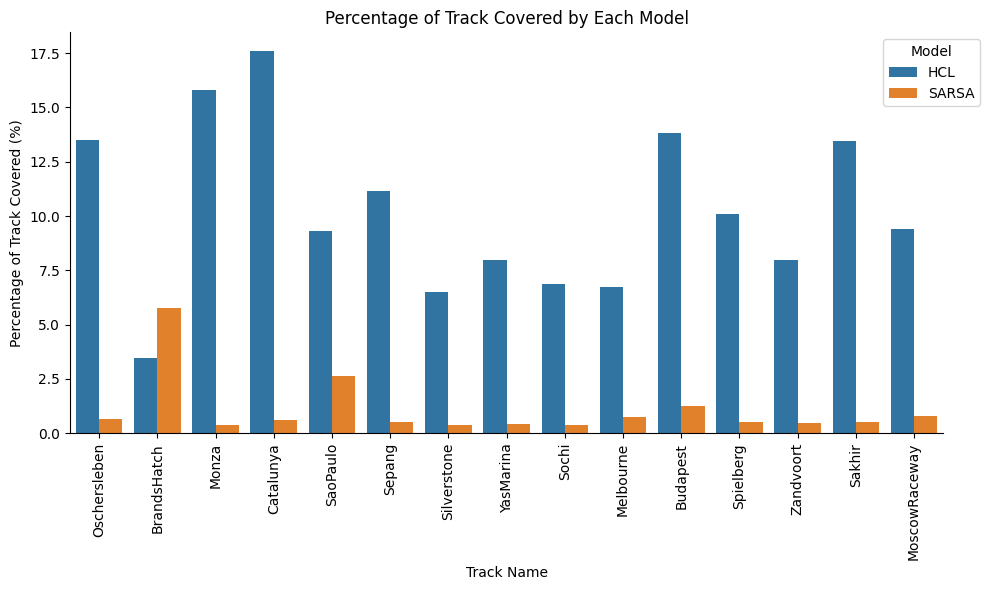

In [12]:
fig = sns.catplot(kind='bar', x='track_name', y='percentage_covered', hue='model', data=combined_df,height=6, aspect=1.5)
fig.set_xticklabels(rotation=90)
fig._legend.remove()
plt.title('Percentage of Track Covered by Each Model')
plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.05, 1))
plt.xlabel('Track Name')
plt.ylabel('Percentage of Track Covered (%)')
plt.tight_layout()

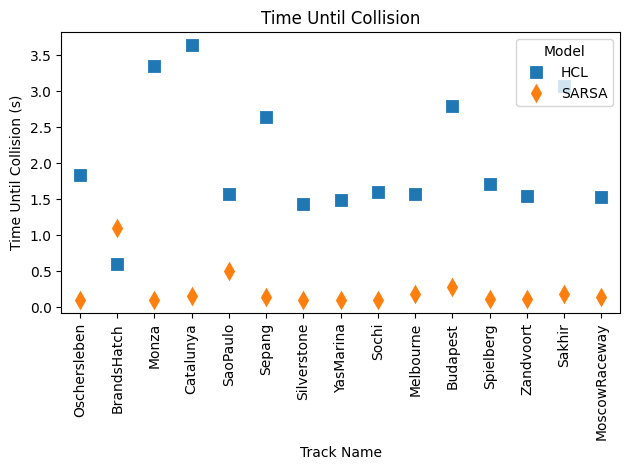

In [13]:
sns.pointplot( x='track_name', y='time_until_collision', hue='model', data=combined_df,markers=['s','d'],linestyles='')
plt.title('Time Until Collision')
plt.legend(title='Model', loc='upper right')
plt.xlabel('Track Name')
plt.xticks(rotation=90)
plt.ylabel('Time Until Collision (s)')
plt.tight_layout()

# Only Centerline Reward

In [24]:
btsp_inference = pd.read_json('trajectory_BTSP/btsp_only_centerline_inference_results.json').T
sarsa_inference = pd.read_json('trajectory_SARSA/sarsa_only_centerline_inference_results.json').T
btsp_inference['model'] = 'HCL'
sarsa_inference['model'] = 'SARSA'

In [25]:
combined_df = pd.concat([btsp_inference, sarsa_inference], axis=0)
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'track_name'}, inplace=True)

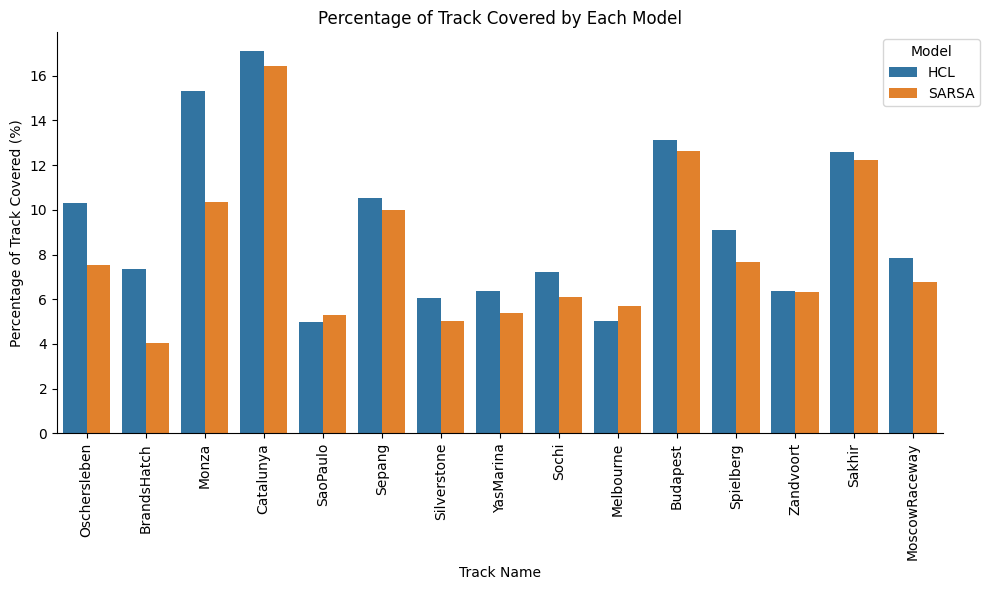

In [26]:
fig = sns.catplot(kind='bar', x='track_name', y='percentage_covered', hue='model', data=combined_df,height=6, aspect=1.5)
fig.set_xticklabels(rotation=90)
fig._legend.remove()
plt.title('Percentage of Track Covered by Each Model')
plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.05, 1))
plt.xlabel('Track Name')
plt.ylabel('Percentage of Track Covered (%)')
plt.tight_layout()

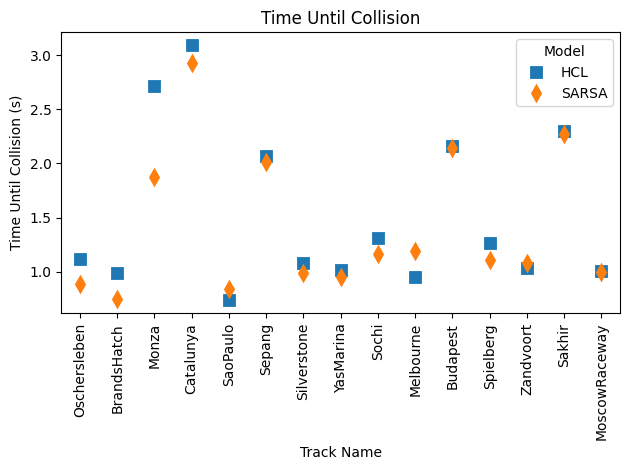

In [27]:
sns.pointplot( x='track_name', y='time_until_collision', hue='model', data=combined_df,markers=['s','d'],linestyles='')
plt.title('Time Until Collision')
plt.legend(title='Model', loc='upper right')
plt.xlabel('Track Name')
plt.xticks(rotation=90)
plt.ylabel('Time Until Collision (s)')
plt.tight_layout()

# Plot the results for multiple inference run

In [ ]:
def analyze_multi_point_inference(btsp_json_path, sarsa_json_path):
    """
    Analyze and visualize results from multi-point inference tests
    
    Args:
        btsp_json_path: Path to the BTSP/HCL model inference results JSON
        sarsa_json_path: Path to the SARSA model inference results JSON
        output_folder: Directory to save visualization results
    """
    # Load JSON data
    with open(btsp_json_path, 'r') as f:
        btsp_results = json.load(f)
    
    with open(sarsa_json_path, 'r') as f:
        sarsa_results = json.load(f)
    
    # Process data into dataframes for visualization
    btsp_data = []
    sarsa_data = []
    
    # Process BTSP/HCL results
    for track_name, track_data in btsp_results.items():
        for point_id, point_data in track_data.items():
            btsp_data.append({
                'track_name': track_name,
                'point_id': point_id,
                'percentage_covered': point_data['percentage_covered'],
                'time_until_collision': point_data['time_until_collision'],
                'distance_travelled': point_data['distance_travelled'],
                'total_track_length': point_data['total_track_length'],
                'avg_speed': point_data['avg_speed'],
                'timesteps': point_data.get('timesteps', 0),
                'model': 'HCL'
            })
    
    # Process SARSA results
    for track_name, track_data in sarsa_results.items():
        for point_id, point_data in track_data.items():
            sarsa_data.append({
                'track_name': track_name,
                'point_id': point_id,
                'percentage_covered': point_data['percentage_covered'],
                'time_until_collision': point_data['time_until_collision'],
                'distance_travelled': point_data['distance_travelled'],
                'total_track_length': point_data['total_track_length'],
                'avg_speed': point_data['avg_speed'],
                'timesteps': point_data.get('timesteps', 0),
                'model': 'SARSA'
            })
    
    # Combine dataframes
    btsp_df = pd.DataFrame(btsp_data)
    sarsa_df = pd.DataFrame(sarsa_data)
    combined_df = pd.concat([btsp_df, sarsa_df], axis=0)
    
    # Create aggregate metrics per track by model
    agg_df = combined_df.groupby(['track_name', 'model']).agg({
        'percentage_covered': ['mean', 'std', 'min', 'max'],
        'time_until_collision': ['mean', 'std', 'min', 'max'],
        'distance_travelled': ['mean', 'std'],
        'avg_speed': ['mean', 'std']
    }).reset_index()
    
    # Flatten multi-index columns
    agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
    
    # 1. Percentage covered comparison
    plt.figure(figsize=(16, 8))
    
    # Main bar plot with error bars
    sns.barplot(
        x='track_name', 
        y='percentage_covered_mean', 
        hue='model',
        data=agg_df,
    )
    plt.title('Average Percentage of Track Covered by each Model')
    plt.xlabel('Track Name')
    plt.ylabel('Avergae coverage (%)')
    plt.xticks(rotation=20)
    plt.legend(title='Model', loc='upper right')
    
   
    # 2. Time until collision comparison
    plt.figure(figsize=(12,6))
    
    sns.pointplot( x='track_name', y='time_until_collision', hue='model', data=combined_df,markers=['s','d'],linestyles='',ci=None)
    
    plt.title('Time Until 1 Collision')
    plt.xlabel('Track Name')
    plt.ylabel('Time Until 1 Collision (s)')
    plt.xticks(rotation=20)
    plt.legend(title='Model', loc='upper right')
    
    plt.tight_layout()
    
    # 3. Average speed comparison
    plt.figure(figsize=(12,6))
    
    sns.boxplot(
        x='track_name', 
        y='avg_speed', 
        hue='model', 
        data=combined_df,
        fliersize=3,
        showfliers=False
    )
    
    plt.title('Average Speed chosen by each Model')
    plt.xlabel('Track Name')
    plt.ylabel('Average Speed (m/s)')
    plt.xticks(rotation=20)
    plt.legend(title='Model', loc='upper right')
    
    plt.tight_layout()    

    return combined_df, agg_df


In [ ]:
btsp_results_path = "trajectory_BTSP/btsp_avg_inference_results.json"
sarsa_results_path = "trajectory_SARSA/sarsa_avg_inference_results.json"
    
# Run analysis
combined_df, agg_df = analyze_multi_point_inference(
    btsp_results_path, 
    sarsa_results_path
)


# Plot the reward and time to collision for each model

In [ ]:
reward_file_BTSP = f'BTSP_220_Multiple_training/rewards.npy'
time_file_BTSP = f'BTSP_220_Multiple_training/times.npy'
path_BTSP = f'BTSP_220_Multiple_training/'

reward_file_sarsa = f'SARSA_220_Multiple_training/rewards.npy'
time_file_sarsa = f'SARSA_220_Multiple_training/times.npy'
path_sarsa = f'SARSA_220_Multiple_training/'

episode_num_BTSP=[0]
for file in os.listdir(path_BTSP):
    if (not file.startswith('reward')) and (not file.startswith('times')) :
        episode_num_BTSP.append(int(int(file.split('_')[1].split('.')[0])))

episode_num_sarsa=[0]
for file in os.listdir(path_sarsa):
    if (not file.startswith('reward')) and (not file.startswith('times')) :
        episode_num_sarsa.append(int(int(file.split('_')[1].split('.')[0])))

episode_num_sarsa = sorted(episode_num_sarsa) 
episode_num_BTSP = sorted(episode_num_BTSP) 

reward = np.load(reward_file_BTSP)
times= np.load(time_file_BTSP)

reward_sarsa = np.load(reward_file_sarsa)
times_sarsa = np.load(time_file_sarsa)

min_episode_num = min(episode_num_BTSP[-1],episode_num_sarsa[-1])

global aggregration_size 
aggregration_size = 3000

def aggregate_and_average(data, aggregation_size=aggregration_size):
    """Aggregates data by summing every 'aggregation_size' values and then averaging."""
    aggregated_data = []
    for i in range(0, len(data), aggregation_size):
        chunk = data[i:i + aggregation_size]
        if len(chunk) > 0:
            aggregated_data.append(np.mean(chunk)) 
    return aggregated_data

aggregated_reward_BTSP = aggregate_and_average(reward[:min_episode_num])
aggregated_times_BTSP = aggregate_and_average(times[:min_episode_num])
aggregated_reward_sarsa = aggregate_and_average(reward_sarsa[:min_episode_num])
aggregated_times_sarsa = aggregate_and_average(times_sarsa[:min_episode_num])

aggregated_episode_num_BTSP = list(range(0, min_episode_num, aggregration_size))[:len(aggregated_reward_BTSP)]
aggregated_episode_num_sarsa = list(range(0, min_episode_num, aggregration_size))[:len(aggregated_reward_sarsa)]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(aggregated_episode_num_BTSP, aggregated_reward_BTSP, label='HCL')

ax[0].plot(aggregated_episode_num_sarsa, aggregated_reward_sarsa, label='SARSA($\lambda$)')
ax[0].set_title('Reward VS Environment interactions')
ax[0].set_xlabel(f'No. of environment interactions')
ax[0].set_ylabel('Average Reward')

ax[1].plot(aggregated_episode_num_BTSP, aggregated_times_BTSP, label='HCL')

ax[1].plot(aggregated_episode_num_sarsa, aggregated_times_sarsa, label='SARSA($\lambda$)')

ax[1].set_title('Time VS Environment interactions')
ax[1].set_xlabel(f'No. of environment interactions')
ax[1].set_ylabel('Time to Collision(s)')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()